ReACT (Reasoning + Acting) is a FrameWork where an LLM (Binding a LLM with TOOLS)

- Reason step by step (eg : decomposes questions, makes decisions)
- Acts by calling tools like search, calculators or retrievers

This Makes it perfect for Agentic RAG : Think -> Retrieve -> Observe -> Reflect -> Final Answer


In [9]:
import os
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END,StateGraph
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages # reducer -> it tells langGraph to merge the updates messages
from dotenv import load_dotenv

In [23]:
## --- loading the docs using an url

docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size= 500, chunk_overlap = 50)
chunks = splitter.split_documents(docs)


Embeddings = HuggingFaceEmbeddings(
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
)

vectorstore = FAISS.from_documents(chunks, Embeddings)
retriever = vectorstore.as_retriever()



In [35]:
result = retriever.invoke("what are autonomous agents?")
result[0].page_content


'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:'

In [ ]:
# Retriever tool function

def retriever_tool_fun  (query : str) -> str  :
    """ Use this tool to fetch the relevant knowledge base info """
    print("Using Retriever Tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])
    
retriever_tool = tool(retriever_tool_fun)


In [60]:
from langchain_community.tools import  WikipediaQueryRun
wiki_tool = WikipediaQueryRun(api_wrapper = WikipediaAPIWrapper())
wiki_tool.name

'wikipedia'

/var/folders/58/7rk_l2gn3lv73f_nlj98yjgc0000gn/T/ipykernel_31804/373865125.py:14: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_agent = create_react_agent(claude, tools)


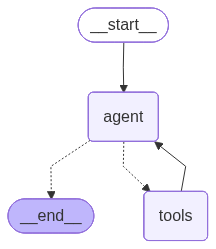

In [63]:
from langchain_anthropic import ChatAnthropic
tools = [retriever_tool, wiki_tool]

api_key = os.getenv("claudeAPI")

claude = ChatAnthropic(
    model = "claude-haiku-4-5-20251001",
    temperature = 0.7,
    api_key = api_key
)


# Create the native LangGraph react agent
react_agent = create_react_agent(claude, tools)
react_agent


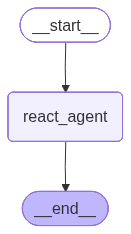

In [64]:
# Agent State

class AgentState(TypedDict) :
    messages : Annotated[Sequence[BaseMessage], add_messages]
    # add_messages is a reducer which tells langGraph to merge the updated messages

# Builder 

builder = StateGraph(AgentState) 

builder.add_node('react_agent', react_agent)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()
graph

In [65]:
user_query  = "what is an agent loop and how does Wikipedia describe autonomous  agents"
state = {"messages" : [HumanMessage(content= user_query)]}
result = graph.invoke(state)

print(result['messages'][-1].content)

Based on the Wikipedia information, here's what I found:

## Agent Loop

While Wikipedia doesn't explicitly define "agent loop" as a standalone concept, it's referenced implicitly in the context of autonomous agents. An **agent loop** is a continuous cycle where an agent:
1. **Perceives** its environment
2. **Decides** on an action based on its goals
3. **Takes** that action
4. **Observes** the results
5. **Repeats** the process

Interestingly, Wikipedia mentions that AutoGPT (an autonomous AI agent) is "known for significant limitations, including a **tendency to get stuck in loops**," which highlights how agent loops can become problematic if not properly managed.

## How Wikipedia Describes Autonomous Agents

According to Wikipedia, autonomous agents are characterized by:

1. **Autonomous Operation**: They "perceive their environment, take actions autonomously to achieve goals, and may improve their performance through machine learning or by acquiring knowledge."

2. **Goal-Directed